# OCO-2 Data Access and Quick Aggregation

### Author: Jon Hobbs
### Date Authored: 10-13-23

This notebook provides a quick demonstration on accessing and summarizing products from the Orbiting Carbon Observatory-2 (OCO-2) hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library, how to read data with xarray, and how to quickly compute and plot small-area aggregate estimates of atmospheric carbon dioxide.

Additional resources for identifying S3 URLs for NASA datasets and for accessing them can be found in the GES DISC cloud tutorials and documentation for the earthaccess Python library.

* [Obtain a List of S3 URLs](https://github.com/nasa/gesdisc-tutorials/blob/main/cloud-tutorials/notebooks/How_to_Obtain_a_List_of_S3_URLs_for_GES_DISC_Collection_Using_Python.ipynb)
* [Accessing MERRA-2 from S3 Bucket](https://github.com/nasa/gesdisc-tutorials/blob/main/cloud-tutorials/notebooks/How_to_Directly_Access_MERRA-2_Data_from_an_S3_Bucket.ipynb)
* [README for earthaccess Python library](https://github.com/nsidc/earthaccess)


## Import Libraries

In [1]:
import earthaccess

## Search CMR Catalogs using earthaccess and Obtain S3 URLs

### Search for OCO-2 Products

Request the desired OCO-2 products for specified date range and product version. Here the search is by the product's short name. The [OCO-2 "lite" CO2 product](https://doi.org/10.5067/8E4VLCK16O6Q) is used for this analysis. 

In [2]:
short_name = 'OCO2_L2_Lite_FP'
version = '11.1r'
start_time = '2020-07-05'
end_time = '2020-07-07'

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    cloud_hosted=True,
    temporal=(start_time,end_time)
)

Granules found: 4


In [3]:
s3_urls_v11 = [granule.data_links(access="direct")[0] for granule in results]
s3_urls_v11

['s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200704_B11100Ar_230603215457s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200705_B11100Ar_230603215543s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200706_B11100Ar_230603215547s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200707_B11100Ar_230603215704s.nc4']

## Open files and aggregate

In [4]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
import boto3

### Get S3 Token

This step requires a valid .netrc file. Confirm your Earthdata Login credentials are stored in a .netrc file below.

In [5]:
auth = earthaccess.login(strategy="netrc")

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 06/22/2025
Using .netrc file for EDL


In [6]:
daac = 'GES_DISC'
temp_s3_credentials = earthaccess.get_s3_credentials(daac=daac, provider=daac)

# Define a function for S3 access credentials (uses earthaccess function)

def begin_s3_direct_access(url: str=daac):
    response = earthaccess.get_s3_credentials(daac=daac, provider=daac)
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

In [7]:
type(fs)

s3fs.core.S3FileSystem

By calling `fs.info()` with S3FS, we can see some of the metadata assigned to files uploaded to S3 buckets.

In [8]:
fs.info(s3_urls_v11[0])

{'ETag': '"d874bac500d8a2ee0030409a5445be5d-1"',
 'LastModified': datetime.datetime(2023, 6, 29, 20, 22, 20, tzinfo=tzutc()),
 'size': 61120215,
 'name': 'gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200704_B11100Ar_230603215457s.nc4',
 'type': 'file',
 'StorageClass': 'INTELLIGENT_TIERING',
 'VersionId': None,
 'ContentType': 'binary/octet-stream'}

In [9]:
### Access dataset

import pandas
import numpy

ltnc = xr.open_dataset(fs.open(s3_urls_v11[0]),
                     decode_cf=True,)
ltsdg = ltnc.sounding_id.values[:]
ltlat = ltnc.latitude.values[:]
ltlon = ltnc.longitude.values[:]
ltxco2 = ltnc.xco2.values[:]
ltflg = ltnc.xco2_quality_flag[:]
ltnc.close()

ltfrm = pandas.DataFrame({'SoundingID': ltsdg, 
                          'Latitude': ltlat, 'Longitude': ltlon, 'XCO2': ltxco2, 'V11QFlag': ltflg})
ltfrm['Sdg10s'] = numpy.floor(ltfrm['SoundingID'] / 1.0e3)
ltfrm = ltfrm[ltfrm['V11QFlag'] == 0]


In [11]:
ltsdg[300:310]

array([2.0200704e+15, 2.0200704e+15, 2.0200704e+15, 2.0200704e+15,
       2.0200704e+15, 2.0200704e+15, 2.0200704e+15, 2.0200704e+15,
       2.0200704e+15, 2.0200704e+15])

In [12]:
ltfrm[1580:1590]

,SoundingID,Latitude,Longitude,XCO2,V11QFlag,Sdg10s
2463,2.020070e+15,-1.506785,-160.217636,412.424652,0.0,2.020070e+12
2464,2.020070e+15,-1.506549,-160.230682,413.083435,0.0,2.020070e+12
2465,2.020070e+15,-1.487572,-160.143677,412.624329,0.0,2.020070e+12
2466,2.020070e+15,-1.487918,-160.156540,412.501129,0.0,2.020070e+12
2467,2.020070e+15,-1.488164,-160.169495,413.055634,0.0,2.020070e+12
2468,2.020070e+15,-1.488305,-160.182510,413.339905,0.0,2.020070e+12
2469,2.020070e+15,-1.488338,-160.195465,413.239349,0.0,2.020070e+12
2470,2.020070e+15,-1.488284,-160.208466,412.659668,0.0,2.020070e+12
2471,2.020070e+15,-1.488145,-160.221497,412.457611,0.0,2.020070e+12
2472,2.020070e+15,-1.487921,-160.234543,411.982330,0.0,2.020070e+12


### Group and Summarize

In [13]:
def qsummary(df,grpvr,vrlst):
    # Summarize with quantiles
    nmtch = df.shape[0] 
    dfout = pandas.DataFrame({'NSmp' : nmtch}, index=[0])
    #dfout[grpvr] = df[grpvr].values[0]
    for j in range(len(vrlst)):
        tmpdt = df[vrlst[j]]
        dtvld = tmpdt[numpy.isfinite(tmpdt)]
        dtvld = dtvld[dtvld != 0.0]
        vrnm = '%s_Med' % (vrlst[j])
        dfout[vrnm] = numpy.median(dtvld)

    return dfout

grpoco = ltfrm.groupby(['Sdg10s'])
ocoqs = grpoco.apply(qsummary,grpvr='Sdg10s',vrlst=['XCO2','Latitude','Longitude'])#,include_groups=False)
ocoqs.reset_index(drop=False,inplace=True)



In [14]:
ocoqs.shape

(1037, 6)

In [15]:
ocoqs[300:310]

,Sdg10s,level_1,NSmp,XCO2_Med,Latitude_Med,Longitude_Med
300,2.020070e+12,0,211,411.343292,-34.974350,83.259407
301,2.020070e+12,0,225,411.440979,-34.475979,83.144669
302,2.020070e+12,0,50,411.589813,-34.133720,83.068466
303,2.020070e+12,0,1,411.468750,-33.480385,82.930206
304,2.020070e+12,0,3,412.202911,-32.105137,82.683243
305,2.020070e+12,0,59,411.530396,-31.759081,82.493492
306,2.020070e+12,0,52,411.668304,-31.103306,82.426590
307,2.020070e+12,0,152,411.182861,-30.686695,82.303864
308,2.020070e+12,0,68,411.071533,-30.234549,82.205315
309,2.020070e+12,0,51,410.795319,-29.528667,82.041924


In [16]:
# Subset
ocoqs = ocoqs[ocoqs['NSmp'] > 30]

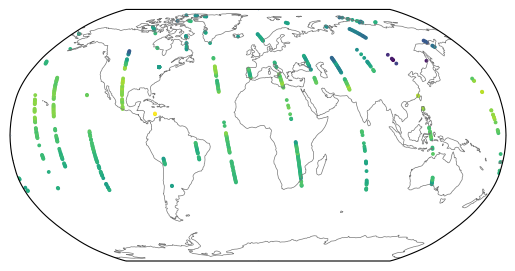

In [17]:
# Plotting, mapping libraries

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline
trnsfrm = ccrs.PlateCarree()

# Set up figure
fig = plt.figure()

pmp = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
cs = plt.scatter(ocoqs['Longitude_Med'],ocoqs['Latitude_Med'],s=3, c=ocoqs['XCO2_Med'], transform = trnsfrm)
#cs = pyplot.pcolormesh(lnarr,ltarr,ctarr[j,:,:],vmin=0,vmax=6000,transform = trnsfrm,cmap=cmpvic)
pmp.coastlines(color='#777777',linewidth=0.5)
pmp.scatter([-180,180,0,0],[0,0,-90,90],s=0.01,c=None,transform=trnsfrm)
plt.show()